# Setup

In [1]:
%matplotlib inline
import sys
import os

import plotly.express as px

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import inspect
from collections import OrderedDict
from functools import partial
import torch
from torch.utils.data import DataLoader

from tqdm import tqdm, trange

import traceback
import warnings
from scipy.stats import gaussian_kde

warnings.filterwarnings("ignore", category=UserWarning)

torch.autograd.set_grad_enabled(False);


In [2]:
from matplotlib import image, transforms

In [3]:
version = 16
SYNTH_DATA_PATH = '../../atrophy_bet/'
BASE_LOG_PATH = 'assets/models/brain_atrophy/SVIExperiment'
FIGURE_SAVE_PATH = f'figures/v{version}'

os.chdir('/ritter/share/projects/larschen/3dscm_1gpu/3dscm')
os.makedirs(FIGURE_SAVE_PATH, exist_ok=True)

In [4]:
from deepscm.experiments.brain_atrophy import synth # noqa: F401
from deepscm.experiments.brain_atrophy.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 10})

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmaps = [cm.Reds, cm.Blues, cm.Greens]
img_cm = 'Greys_r'
diff_cm = 'seismic'

In [6]:
from deepscm.datasets.atrophy_data import NvidiaDataset

synth_test = NvidiaDataset(train=False)
test_loader = DataLoader(synth_test, batch_size=4, shuffle=False, num_workers=16)

synth_train = NvidiaDataset(train=True)
test_loader = DataLoader(synth_train, batch_size=4, shuffle=False, num_workers=16)

In [7]:
var_name = {'brain_vol': 'b', 'sex': 's', 'age': 'a'}
value_fmt = {
    'ventricle_vol': lambda s: rf'{float(s):.4g}\,\mathrm{{ml}}',
    'brain_vol': lambda s: rf'{float(s):.4g}\,\mathrm{{ml}}',
    'age': lambda s: rf'{int(s):d}\,\mathrm{{y}}',
    'sex': lambda s: '{}'.format(['\mathrm{female}', '\mathrm{male}'][int(s)])
}

def fmt_intervention(intervention):
    if isinstance(intervention, str):
        var, value = intervention[3:-1].split('=')
        return f"$do({var_name[var]}={value_fmt[var](value)})$"
    else:
        all_interventions = ', '.join([f'{var_name[k]}={value_fmt[k](v)}' for k, v in intervention.items()])
        return f"$do({all_interventions})$"

In [8]:
def prep_data(batch):
    x = batch['image'].unsqueeze(0) #* 255.
    age = batch['age'].unsqueeze(0).unsqueeze(0).float()
    sex = batch['sex'].unsqueeze(0).unsqueeze(0).float()
    brain_vol = batch['brain_vol'].unsqueeze(0).unsqueeze(0).float()
    ventricle_vol = batch['ventricle_vol'].unsqueeze(0).unsqueeze(0).float()

    x = x.float()

    return {'x': x, 'age': age, 'sex': sex, 'ventricle_vol': ventricle_vol, 'brain_vol': brain_vol}

## Metrics

In [9]:
columns = [
    'exp', 'loss', 'log p(x)', 'log p(age)', 'log p(sex)', 'log p(ventricle_vol)', 
    'log p(brain_vol)', 'log p(z) - log q(z)', 'p(z)', 'q(z)'
]
metrics_df = pd.DataFrame(columns=columns)
experiments = ['ConditionalVISEM']

In [10]:
for exp in experiments:
    try:
        print(exp)
        metrics = torch.load(f'{BASE_LOG_PATH}/{exp}/version_{version}/metrics.pt')
        for k, v in metrics.items():
            print(f'{k}: {v:.0f}')
        row = {k.replace('test/', ''): np.array(v) for k, v in metrics.items()}
        metrics_df.loc[len(metrics_df)] = {'exp': exp, **row}
    except:
        pass

ConditionalVISEM
test/loss: 6819065562
test/log p(x): -435965920
test/log p(age): -3
test/log p(score): -2
test/log p(sex): -1
test/log p(ventricle_volume): -4
test/log p(brain_volume): -6
test/p(z): -628
test/q(z): 3280
test/log p(z) - log q(z): -3908


In [11]:
recon_mae = {}
for exp in experiments:
    try:
        reconstructions = torch.load(f'{BASE_LOG_PATH}/{exp}/version_{version}/reconstruction.pt')
        diff = []
        for i in trange(reconstructions['x'].shape[0]-1): # lpc
            diff += [reconstructions['x'][i] - (synth_test[i]['image'])]
        recon_mae[exp] = np.mean(np.abs(torch.stack(diff).numpy()))
    except Exception as e:
        print(e)
    
metrics_df.loc[:, 'recon_mae'] = list(recon_mae.values())

100%|██████████| 499/499 [11:45<00:00,  1.41s/it]


In [12]:
metrics_df

exp              loss      log p(x) log p(age)   log p(sex)  \
0  ConditionalVISEM  6819065562.49646  -435965920.0  -3.399682  -0.69338787   

  log p(ventricle_vol) log p(brain_vol) log p(z) - log q(z)       p(z)  \
0                  NaN              NaN          -3908.1592  -627.8922   

        q(z)  recon_mae  
0  3280.2676   8.248249

# Loaded Models

In [19]:
models = {}
loaded_models = {}

for exp in experiments:
    try:
        checkpoint_path = f'{BASE_LOG_PATH}/{exp}/version_{version}/'

        base_path = os.path.join(checkpoint_path, 'checkpoints')
        checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])

        ckpt = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        hparams = ckpt['hyper_parameters']
        
        model_class = MODEL_REGISTRY[hparams['model']]

        model_params = {
            k: v for k, v in hparams.items() if (k in inspect.signature(model_class.__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters)
        }
        
        new_state_dict = OrderedDict()

        for key, value in ckpt['state_dict'].items():
            new_key = key.replace('pyro_model.', '')
            new_state_dict[new_key] = value
            
        loaded_model = model_class(**model_params)
        loaded_model.load_state_dict(new_state_dict)
        
        for p in loaded_model._buffers.keys():
            if 'norm' in p:
                setattr(loaded_model, p, getattr(loaded_model, p))
                
        loaded_model.eval()
                
                
        loaded_models[exp] = loaded_model
        
        def sample_pgm(num_samples, model):
            with pyro.plate('observations', num_samples):
                return model.pgm_model()
        
        models[exp] = partial(sample_pgm, model=loaded_model)
    except Exception as e:
        print(e)
        traceback.print_exc()

__init__() missing 1 required positional argument: 'context_dim'


Traceback (most recent call last):
  File "/tmp/ipykernel_445796/2142995398.py", line 28, in <module>
    loaded_model = model_class(**model_params)
  File "/ritter/share/projects/larschen/3dscm_1gpu/3dscm/deepscm/experiments/brain_atrophy/synth/sem_vi/conditional_sem.py", line 17, in __init__
    super().__init__(**kwargs)
TypeError: __init__() missing 1 required positional argument: 'context_dim'


In [14]:
import scipy.misc
from scipy import ndimage

# Dataset Samples

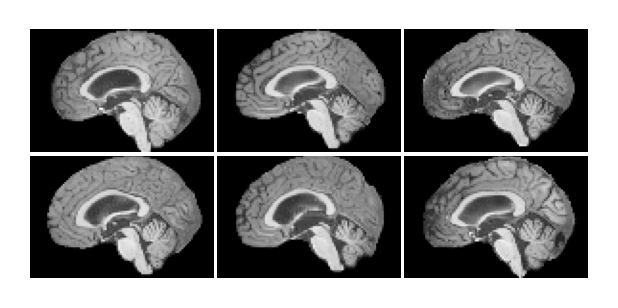

In [15]:
slice = 'coronal' # axial sagittal coronal, 

num_cols = 3
num_rows = 2
num = num_cols * num_rows

fig = plt.figure(figsize=(num_cols * 0.8, num_rows * 0.8))

save_name = 'synthetic_samples'
degrees = 180

for i in range(num):
    d = synth_test[np.random.randint(0,20)]['image'] #* 255
    img = ndimage.rotate(d.squeeze(), degrees)
    
    shape = img.shape
    if slice == 'axial':
        gs = fig.add_gridspec(num_rows, num_cols, wspace=-0.6, hspace=0.01)
        ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        ax.imshow(ndimage.rotate(img[:,:,37], 270), img_cm, vmin=0, vmax=255)
    elif slice == 'sagittal':
        gs = fig.add_gridspec(num_rows, num_cols, wspace=-0.01, hspace=0.01)
        ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        ax.imshow(ndimage.rotate(img[:,shape[-2]//2,:], 90), img_cm, vmin=0, vmax=255)
    else:
        gs = fig.add_gridspec(num_rows, num_cols, wspace=0.02, hspace=-0.48)
        ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        ax.imshow(ndimage.rotate(img[shape[-3]//2,:,:],90), img_cm, vmin=0, vmax=255)
        
    ax.axis('off')
   
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)

plt.show()

# Unconditional Samples

In [16]:
slice = 'sagittal' # sagittal coronal axial
num_cols = 4
num_rows = 2
num = num_cols * num_rows


for exp in loaded_models.keys():
    print(exp)

    samples = loaded_models[exp].sample(num)
        
    samples = {
        'x': samples[0],
    }
    
    save_name = f'{exp}_uncond_samples'

    fig = plt.figure(figsize=(num_cols, num_rows))
    #gs = fig.add_gridspec(num_rows, num_cols, wspace=-.4, hspace=-.1)

    for i in range(num):
        x = samples['x'][i]
        
        #ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        
        if slice == 'axial':
            gs = fig.add_gridspec(num_rows, num_cols, wspace=-0.6, hspace=0.01)
            ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
            ax.imshow(ndimage.rotate(x.numpy().squeeze()[:,:,37], 90), img_cm, vmin=0, vmax=255)
        elif slice == 'sagittal':
            gs = fig.add_gridspec(num_rows, num_cols, wspace=-0.01, hspace=0.01)
            ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
            ax.imshow(ndimage.rotate(x.numpy().squeeze()[:,shape[-2]//2,:], 90), img_cm, vmin=0, vmax=255)
        else:
            gs = fig.add_gridspec(num_rows, num_cols, wspace=0.02, hspace=-0.48)
            ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
            ax.imshow(ndimage.rotate(x.numpy().squeeze()[shape[-3]//2,:,:],90), img_cm, vmin=0, vmax=255)
        
        #ax.imshow(x.numpy().squeeze(), img_cm, vmin=0, vmax=255)
        ax.axis('off')
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)
    plt.tight_layout()
    plt.show()

# Conditional Samples

In [23]:
brain_volumes = 800. + 500 * torch.arange(3, dtype=torch.float)
brain_volume_range = brain_volumes.repeat(3).unsqueeze(1)

ventricle_volumes = 10. + 60 * torch.arange(3, dtype=torch.float)
ventricle_volume_range = ventricle_volumes.repeat_interleave(3).unsqueeze(1)

z_range = torch.randn([1, hparams['latent_dim']], dtype=torch.float).repeat((9, 1))

cond_data = {'brain_volume': brain_volume_range, 'ventricle_volume': ventricle_volume_range, 'z': z_range}
samples, *_ = pyro.condition(loaded_model.sample, data=cond_data)(9)

NameError: name 'loaded_model' is not defined

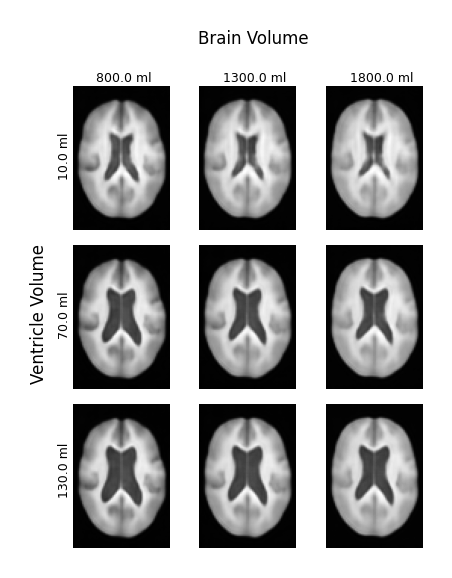

In [32]:
num_cols = 3
fig = plt.figure(figsize=(2, 2))
gs = fig.add_gridspec(3, 3, wspace=-0.4, hspace=0.1)

for i in range(9):
    cond_sample = samples.data[i]
    
    ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
    ax.imshow(ndimage.rotate(cond_sample.squeeze()[:,:,37], 90), 'gray')
    
    if i < 3:
        ax.text(15,-3, f'{brain_volume_range[i].item()} ml', fontsize=3)
    if i%3==0:
        ax.text(-10,60, f'{ventricle_volume_range[i].item()} ml', fontsize=3, rotation=90)
        
    ax.axis('off')
        
fig.text(0.43, 0.95, 'Brain Volume', fontsize=4)
fig.text(0.15, 0.39, 'Ventricle Volume', fontsize=4, rotation=90)


fig.tight_layout()

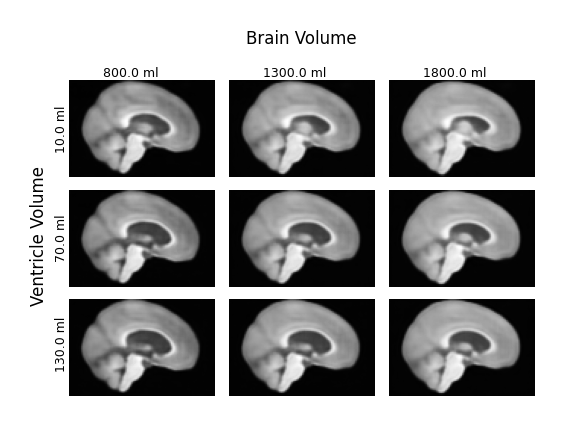

In [20]:
fig = plt.figure(figsize=(2, 2))
gs = fig.add_gridspec(3, 3, wspace=0.1, hspace=-0.55)

for i in range(9):
    cond_sample = samples.data[i]
    
    ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
    ax.imshow(ndimage.rotate(cond_sample.squeeze()[30,:,:], 90), 'gray')
    
    if i < 3:
        ax.text(22,-3, f'{brain_volume_range[i].item()} ml', fontsize=3)
    if i%3==0:
        ax.text(-10,45, f'{ventricle_volume_range[i].item()} ml', fontsize=3, rotation=90)
        
    ax.axis('off')
        
fig.text(0.42, 0.82, 'Brain Volume', fontsize=4)
fig.text(0.06, 0.39, 'Ventricle Volume', fontsize=4, rotation=90)


fig.tight_layout()

(-0.5, 63.5, 95.5, -0.5)

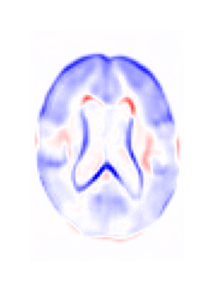

In [21]:
diff = samples.data[6]-samples.data[8]

fig, ax = plt.subplots(figsize=(1,1))
ax.imshow(ndimage.rotate((diff)[0,:,:,37], 90), 'seismic', vmin=-200, vmax=200)
ax.axis('off')

(-0.5, 63.5, 95.5, -0.5)

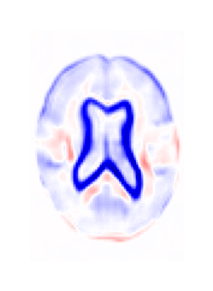

In [22]:
diff = samples.data[6]-samples.data[1]

fig, ax = plt.subplots(figsize=(1,1))
ax.imshow(ndimage.rotate((diff)[0,:,:,37], 90), 'seismic', vmin=-200, vmax=200)
ax.axis('off')

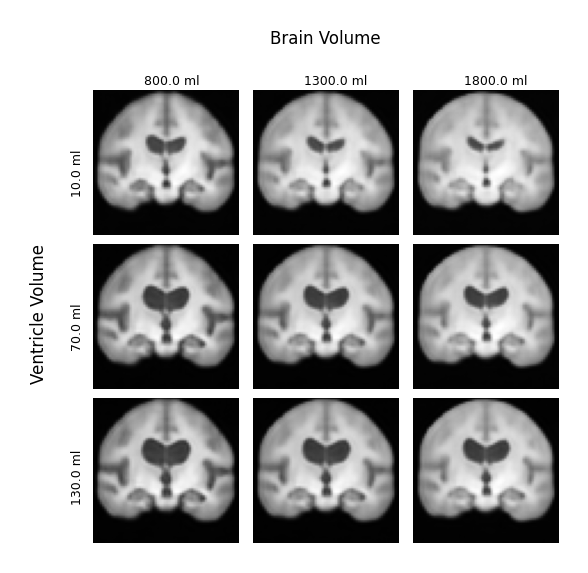

In [23]:
fig = plt.figure(figsize=(2, 2))
gs = fig.add_gridspec(3, 3, wspace=0.1, hspace=0)

for i in range(9):
    cond_sample = samples.data[i]
    
    ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
    ax.imshow(ndimage.rotate(cond_sample.squeeze()[:,48,:], 90), 'gray')
    
    if i < 3:
        ax.text(22,-3, f'{brain_volume_range[i].item()} ml', fontsize=3)
    if i%3==0:
        ax.text(-10,45, f'{ventricle_volume_range[i].item()} ml', fontsize=3, rotation=90)
        
    ax.axis('off')
        
fig.text(0.42, 0.95, 'Brain Volume', fontsize=4)
fig.text(0.02, 0.39, 'Ventricle Volume', fontsize=4, rotation=90)


fig.tight_layout()

# Reconstructions

ConditionalVISEM


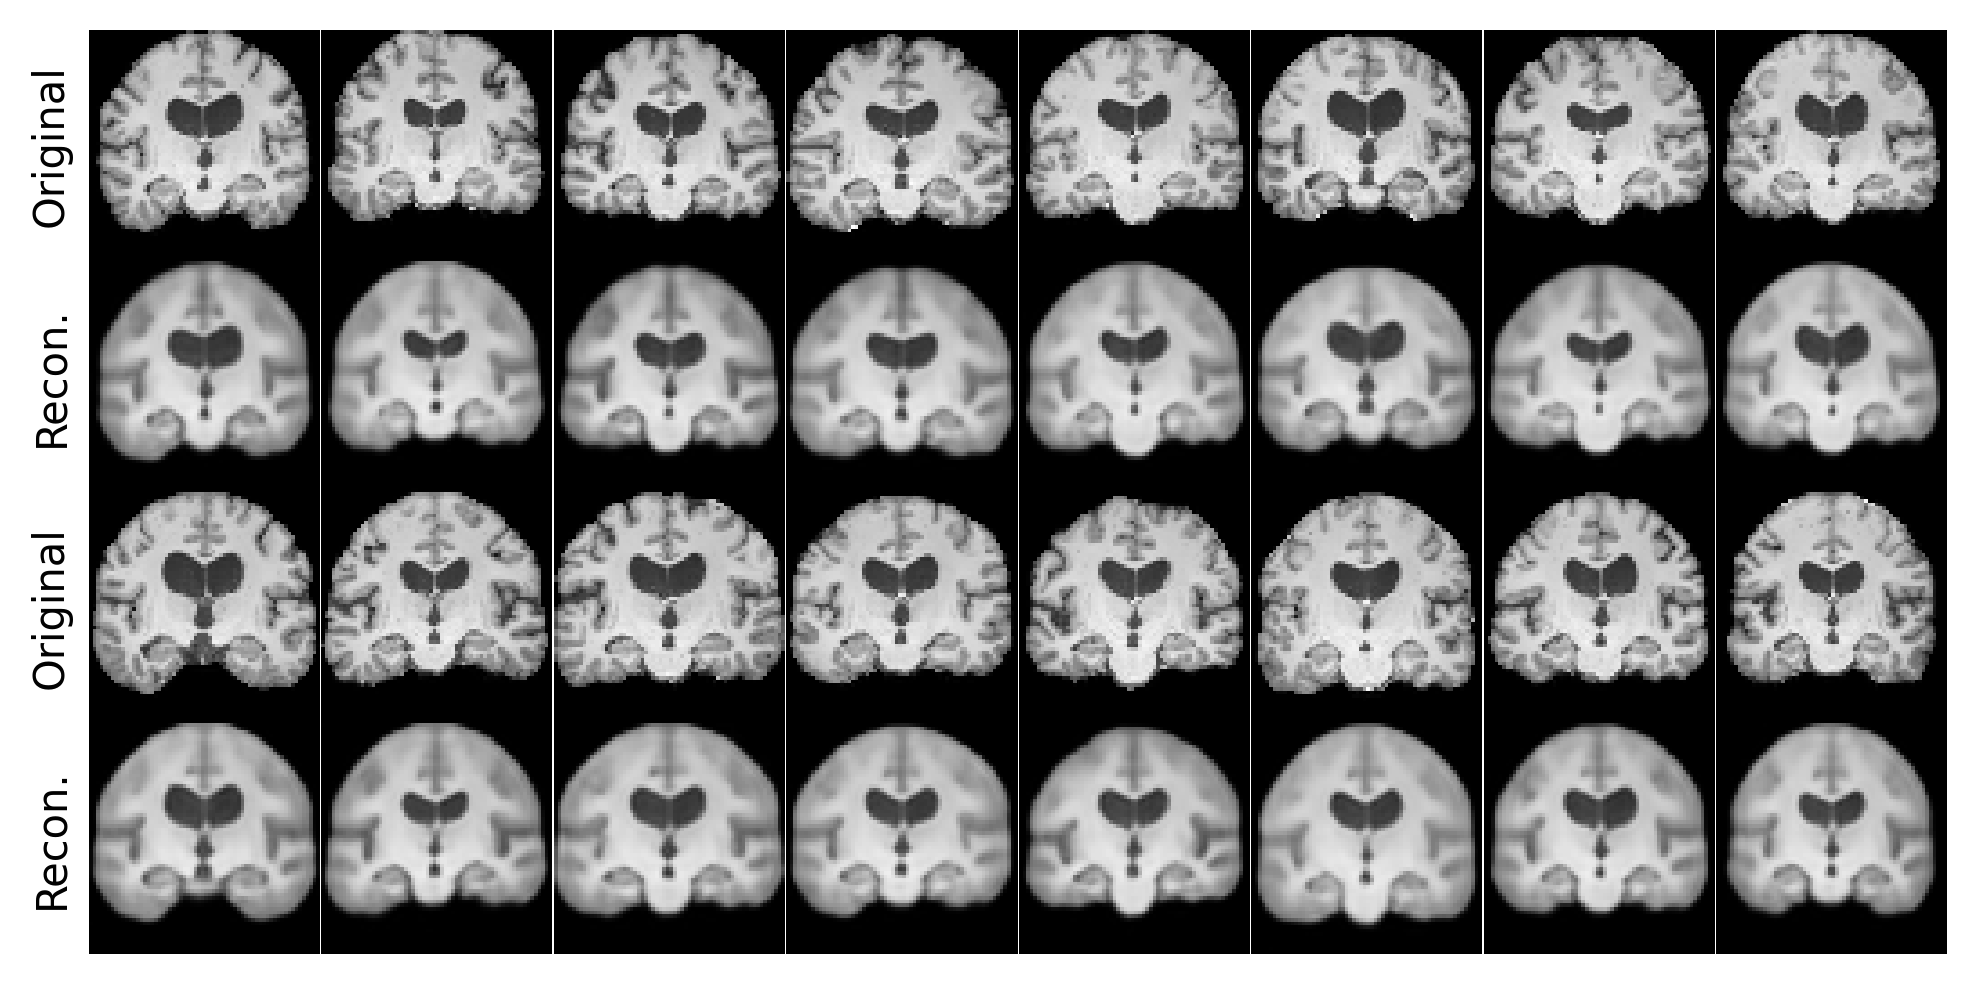

In [24]:
num_samples = 8
num_rows = 2

titles = {
    'ConditionalVISEM': 'Full',
}

save_name = 'reconstructions'

fig = plt.figure(figsize=(num_samples * 1., 2. * num_rows))

gs = fig.add_gridspec(2 * num_rows, num_samples, wspace=0., hspace=0.0)

for i in range(num_samples * num_rows):
    col = i % num_samples
    row = i // num_samples
    
    img = synth_test[i]['image']
    img = ndimage.rotate(img.squeeze(), 180)
    
    ax = fig.add_subplot(gs[row * 2, col])
    ax.imshow(ndimage.rotate(img[:,48,:], 90), img_cm, vmin=0, vmax=255)
    if col == 0:
        ax.set_ylabel('Original')
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')
        
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

exp = 'ConditionalVISEM'
print(exp)
reconstructions = torch.load(f'{BASE_LOG_PATH}/{exp}/version_{version}/reconstruction.pt')

for i in range(num_samples * num_rows):
    col = i % num_samples
    row = i // num_samples

    img = reconstructions['x'][i]
    img = ndimage.rotate(img.squeeze(), 180)

    ax = fig.add_subplot(gs[row * 2 + 1, col])
    ax.imshow(ndimage.rotate(img[:,48,:],90), img_cm, vmin=0, vmax=255)
    if col == 0:
        ax.set_ylabel('Recon.')
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')

    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
            
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)

plt.show()

ConditionalVISEM


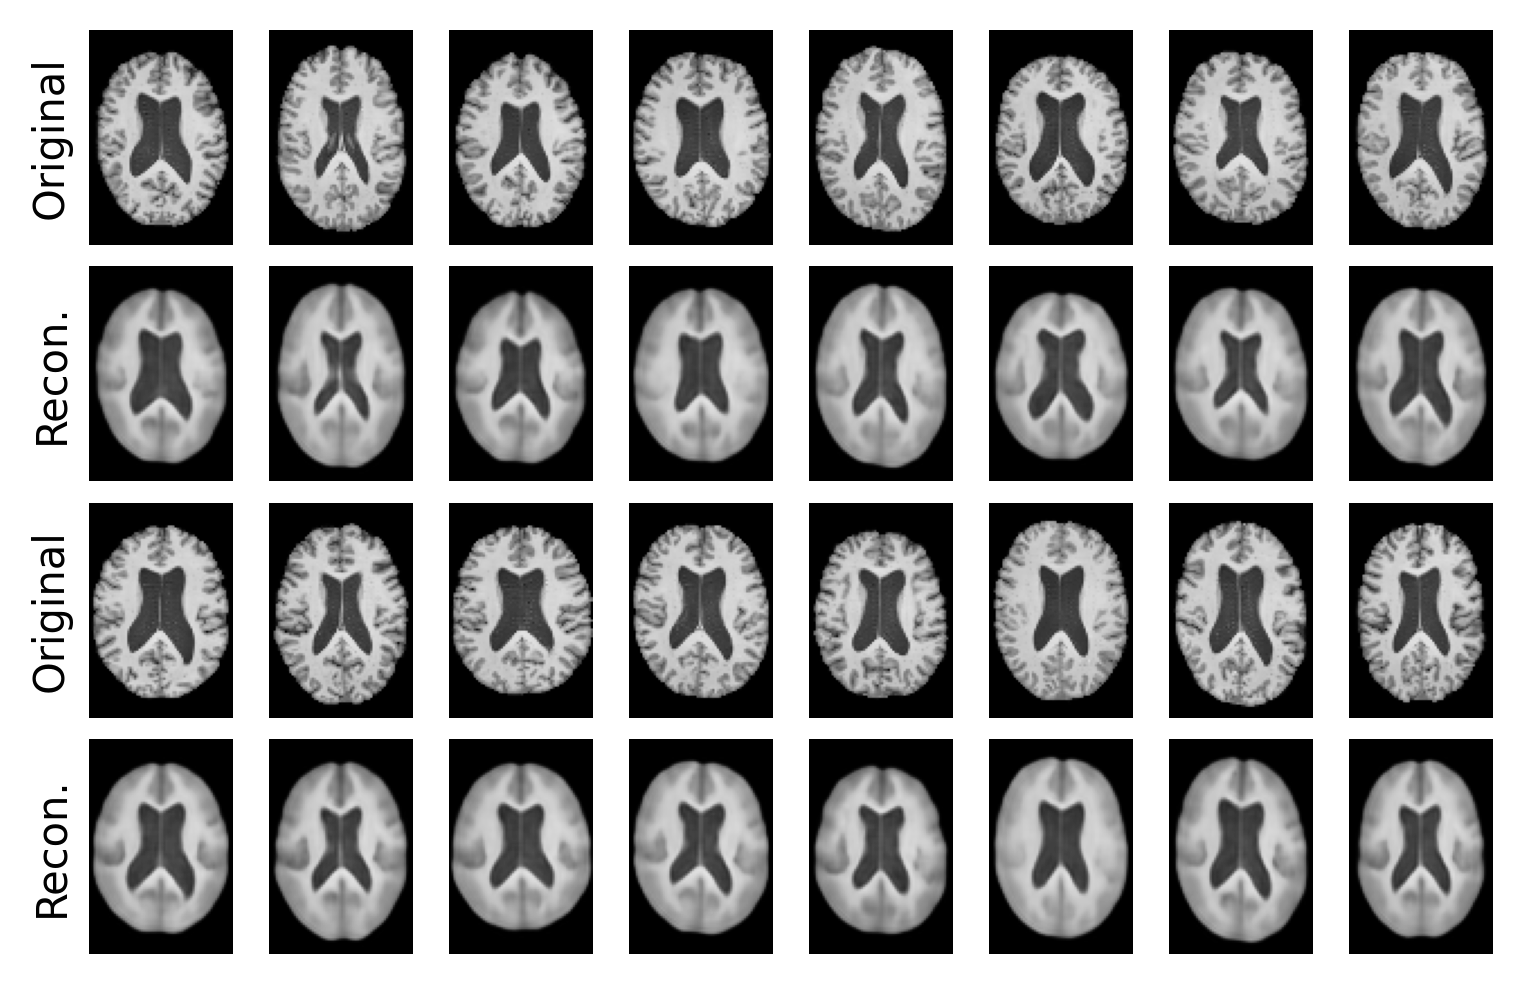

In [25]:
num_samples = 8
num_rows = 2

titles = {
    'ConditionalVISEM': 'Full',
}

save_name = 'reconstructions'

fig = plt.figure(figsize=(num_samples * 1., 2. * num_rows))

gs = fig.add_gridspec(2 * num_rows, num_samples, wspace=-0.7, hspace=0.1)

for i in range(num_samples * num_rows):
    col = i % num_samples
    row = i // num_samples
    
    img = synth_test[i]['image'] 
    img = ndimage.rotate(img.squeeze(), 180)
    
    ax = fig.add_subplot(gs[row * 2, col])
    ax.imshow(ndimage.rotate(img[:,:,37], 270), img_cm, vmin=0, vmax=255)
    if col == 0:
        ax.set_ylabel('Original')
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')
        
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

exp = 'ConditionalVISEM'
print(exp)
reconstructions = torch.load(f'{BASE_LOG_PATH}/{exp}/version_{version}/reconstruction.pt')

for i in range(num_samples * num_rows):
    col = i % num_samples
    row = i // num_samples

    img = reconstructions['x'][i]
    img = ndimage.rotate(img.squeeze(), 180)

    ax = fig.add_subplot(gs[row * 2 + 1, col])
    ax.imshow(ndimage.rotate(img[:,:,37],270), img_cm, vmin=0, vmax=255)
    if col == 0:
        ax.set_ylabel('Recon.')
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')

    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
            
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)

plt.show()

# Age, Brain, Sex KDE

In [26]:
model_name = 'ConditionalVISEM'

def pgm_model(n):
    with pyro.plate('observations', n):
        return loaded_models[model_name].pgm_model()
    
age_range = torch.arange(40, 80, 0.1, dtype=torch.float)
bvol_range = torch.arange(8e2, 18e2, 5e1, dtype=torch.float)
vvol_range = torch.arange(1e1, 1.5e2, 1, dtype=torch.float)

age_range_, bvol_range_ = [x.reshape(-1, 1) for x in torch.meshgrid(age_range, bvol_range)]
#age_range_, vvol_range_ = [x.reshape(-1, 1) for x in torch.meshgrid(age_range, vvol_range)]

df = pd.DataFrame(columns=["age", "sex", "brain volume", "probability"])

prob_maps = {'model': {}}
for sex in [0, 1]:
    cond_data = {
        'age': age_range_,
        'brain_vol': bvol_range_,
        #'ventricle_vol': vvol_range_,
        'sex': torch.tensor(float(sex)).expand(age_range_.shape),
    }

    with torch.no_grad():
        trace = pyro.poutine.trace(pyro.condition(pgm_model, data=cond_data)).get_trace(age_range_.shape[0])
        trace.compute_log_prob()

    log_prob_model = trace.nodes['age']['log_prob'] + trace.nodes['brain_volume']['log_prob']
    prob_maps['model'][f"{['female', 'male'][sex]}"] = {
        'age': trace.nodes['_RETURN']['value'][0],
        'brain_vol': trace.nodes['_RETURN']['value'][3],
        'log_prob': log_prob_model.reshape(age_range.shape[0], bvol_range.shape[0])
    }
    
    df_ = pd.DataFrame()
    df_["age"] = trace.nodes['_RETURN']['value'][0].squeeze()
    df_["brain volume"] =trace.nodes['_RETURN']['value'][4].squeeze()
    df_["probability"] = np.exp(log_prob_model)
    df_["sex"] = np.full((len(df_)), "Male" if sex else "Female")

    df = df.append(df_)

prob_maps['true'] = {}
for sex in [0, 1]:
    cond_data = {
        'age': age_range_,
        'brain_vol': bvol_range_,
        'sex': torch.tensor(float(sex)).expand(age_range_.shape)
    }

    sel = synth_test.subjects['sex'] == sex
    data = torch.stack([torch.tensor(synth_test.subjects['age'][sel].values), torch.tensor(synth_test.subjects['brain_vol'][sel].values)], -1).numpy()
    kde = gaussian_kde(data.T)
    log_prob = np.log(kde(torch.stack([age_range_.flatten(), bvol_range_.flatten()], 0)))
    prob_maps['true'][rf"$s=\mathrm{{{['female', 'male'][sex]}}}$"] = {
        'age': age_range_,
        'brain_vol': bvol_range_,
        'log_prob': torch.as_tensor(log_prob.reshape(age_range.shape[0], bvol_range.shape[0]))
    }

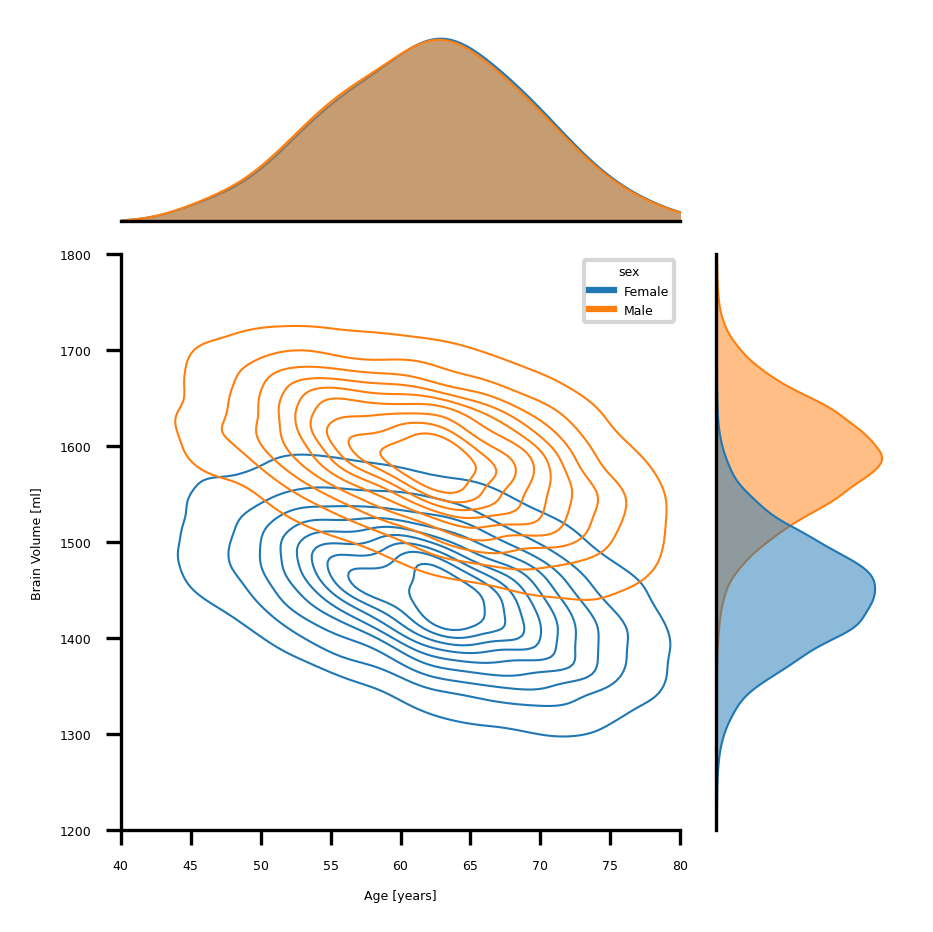

In [34]:
plt.rcParams.update({'font.size': 3})

fig, axes = plt.subplots(2, 2, sharex=True, figsize=(3,3), gridspec_kw={'height_ratios': [1, 3], 'width_ratios':[3,1]})

da = 80 - 40
fem_prob = np.exp(prob_maps['model']['female']['log_prob'])
marg_a_f = fem_prob.sum(1) * da
male_prob = np.exp(prob_maps['model']['male']['log_prob'])
marg_a_m = male_prob.sum(1) * da

db = 18e2 - 8e2
fem_prob_brain = np.exp(prob_maps['model']['female']['log_prob'])
marg_a_f_brain = fem_prob.sum(0) * db
male_prob_brain = np.exp(prob_maps['model']['male']['log_prob'])
marg_a_m_brain = male_prob.sum(0) * db

df_marg = df.groupby(['age', 'sex', 'brain volume']).sum().reset_index()

sns.kdeplot(ax=axes[1,0], x=df["age"], y=df["brain volume"], weights=df["probability"], hue=df["sex"], linewidths=0.5)
sns.kdeplot(ax=axes[0,0], x=age_range, weights=marg_a_f, linewidth=0.5, shade=True, alpha=0.5)
sns.kdeplot(ax=axes[0,0], x=age_range, weights=marg_a_m, linewidth=0.5, shade=True, alpha=0.5)
sns.kdeplot(ax=axes[1,1], y=df_marg['brain volume'], weights=df_marg['probability'], hue=df_marg['sex'], linewidth=0.5, shade=True, alpha=0.5)

axes[1,1].get_shared_x_axes().remove(axes[1,1])
axes[1,1].get_shared_x_axes().remove(axes[1,1])
axes[1,1].set_yticklabels(['']*10)
axes[1,1].spines[['bottom','right', 'top']].set_visible(False)
axes[1,1].get_xaxis().set_visible(False)
axes[1,1].get_yaxis().set_visible(False)
axes[1,1].get_legend().remove()
axes[1,1].set_xlim(0,0.004)
axes[1,1].set_ylim(1200,1800)


axes[0,0].spines[['left','right', 'top']].set_visible(False)
axes[0,0].get_yaxis().set_visible(False)
axes[0,0].get_xaxis().set_visible(False)
axes[0,0].set_yticks([])

axes[1,0].set_ylim(1200,1800)
axes[1,0].set_xlim(40,80)

axes[1,0].set_xlabel('Age [years]')
axes[1,0].set_ylabel('Brain Volume [ml]')

axes[1,0].spines[['right', 'top']].set_visible(False)

axes[0,1].axis('off')

fig.tight_layout()

# Counterfactuals

In [28]:
def plot_intervention_range(bp, interventions, idx, normalise_all=True):
    fig, ax = plt.subplots(2, len(interventions) + 1, figsize=(1.6 * len(interventions), 2), gridspec_kw=dict(wspace=0, hspace=0))
    lim = 0
    
    imgs = []
    for intervention in interventions:
        f = os.path.join(bp, f'{intervention}.pt')
        samples = torch.load(f)

        main_intervention = intervention[3:].split('=')[0]

        imgs += [samples['x'][idx]]
        
        x_test = (synth_test[idx]['image'] * 255.)
        diff = (x_test - imgs[-1].numpy()).squeeze()

        lim = np.maximum(lim, np.absolute(diff).max())

    for i, intervention in enumerate(interventions):
        
        main_intervention = intervention[3:].split('=')[0]
        
        val = synth_test[idx][main_intervention]

        v_name = var_name[main_intervention]
        v_val = value_fmt[main_intervention](val)
        i_val = value_fmt[main_intervention](float(intervention[3:-1].split('=')[1]))
        
        x = imgs[i]
        x_test = (synth_test[idx]['image'] * 255.)
        diff = (x_test[:,:,48,:] - x[:,:,48,:].numpy()).squeeze()
        if not normalise_all:
            lim = np.absolute(diff).max()


        ax[0, i+1].set_title(f"$do({v_name}={i_val})$", fontsize=6)
        
        x = ndimage.rotate(x.squeeze()[:,48,:], 90)
        ax[0, i+1].imshow(x, 'Greys_r')
        
        diff = ndimage.rotate(diff, 90)
        ax[1, i+1].imshow(diff, 'seismic', clim=[-100, 100])

    for i in range(len(interventions)+1):
        for axi in ax[:, i]:
            axi.axis('off')
            axi.xaxis.set_major_locator(plt.NullLocator())
            axi.yaxis.set_major_locator(plt.NullLocator())

    #x_test = ndimage.rotate(x_test.squeeze(), 180)
    ax[0, 0].imshow(ndimage.rotate(x_test.squeeze()[:,48,:], 90), 'Greys_r')
    ax[0, 0].set_title('Original', fontsize=6)
    #ax[0, 0].axis('off')
    #ax[0, 0].xaxis.set_major_locator(plt.NullLocator())
    #ax[0, 0].yaxis.set_major_locator(plt.NullLocator())
    
    # suptitle = '$s={sex}; a={age}; b={brain_vol}; v={ventricle_vol}$'.format(
    #     **{att: value_fmt[att](synth_test.subjects[idx][att]) for att in ('sex', 'age', 'brain_volume', 'ventricle_volume')}
    # )
    # fig.suptitle(suptitle, fontsize=6, y=1.04)
    

    #fig.tight_layout()

    plt.savefig(f"{FIGURE_SAVE_PATH}/intervention_range_{idx}_normalised_{normalise_all}_{np.random.randint(1,50)}.png", bbox_inches='tight', pad_inches=0)
    plt.show()

# Counterfactual Traversals

In [29]:
def plot_gen_intervention_range(model_name, all_interventions, save_name, normalise_all=True, num_samples=32):
    
    
    num_idx = len(all_interventions)
    num_inter = len(all_interventions[0][1])
    
    hrs = [0.2 if ((i + 1) % 3) == 0 else 1 for i in range(2 * num_idx + num_idx - 1)]
    fig, ax = plt.subplots(2 * num_idx + num_idx - 1, (num_inter + 1), figsize=(1.8 * (num_inter + 1), 4*num_idx),
                           gridspec_kw=dict(wspace=0, hspace=0, height_ratios=hrs))
    lim = 0
    
    for cur_ex, (idx, interventions) in enumerate(all_interventions):
        orig_data = prep_data(synth_test[idx])

        imgs = []
        for intervention in interventions:
            pyro.clear_param_store()
            cond = {k: torch.tensor([[v]]) for k, v in intervention.items()}
            counterfactual = loaded_models[model_name].counterfactual(orig_data, cond, num_samples)

            imgs += [counterfactual['x']]

            diff = (orig_data['x'] - imgs[-1]).squeeze()

            lim = np.maximum(lim, diff.abs().max())
            
        x_test = orig_data['x']
        ax[cur_ex * 3, 0].imshow(x_test.squeeze(), 'Greys_r', vmin=0, vmax=255)
        ax[cur_ex * 3, 0].set_title('Original')

        for i, intervention in enumerate(interventions):
            x = imgs[i]
            
            diff = (x_test - x).squeeze()
            if not normalise_all:
                lim = diff.abs().max()

            ax[cur_ex * 3, i + 1].set_title(fmt_intervention(intervention))
            ax[cur_ex * 3, i + 1].imshow(x.squeeze(), 'Greys_r', vmin=0, vmax=255)

            ax[cur_ex * 3 + 1, i + 1].imshow(diff, 'seismic', clim=[-lim, lim])
        
        att_str = '$s={sex}$\n$a={age}$\n$b={brain_vol}$\n$l={lesion_vol}$'.format(
            **{att: value_fmt[att](orig_data[att].item()) for att in ('sex', 'age', 'brain_vol', 'lesion_vol')}
        )
        
        ax[cur_ex * 3 + 1, 0].text(0.5, 0.5, att_str, horizontalalignment='center',
                                   verticalalignment='center', transform=ax[cur_ex * 3 + 1, 0].transAxes,
                                   fontsize=mpl.rcParams['axes.titlesize'])
        
    for axi in ax.ravel():
        axi.axis('off')
        axi.xaxis.set_major_locator(plt.NullLocator())
        axi.yaxis.set_major_locator(plt.NullLocator())

    #plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)
        
    plt.show()

In [30]:
idx = [10, 20]
model_name = 'ConditionalVISEM'

orig_data = prep_data(synth_test[idx])

interventions = [
    (10, [
        {'sex': 1.},
        {'age': 50.},
        {'age': 80.},
        {'brain_vol': 1000.},
        {'brain_vol': 1400.},
        {'lesion_vol': 5.},
        {'lesion_vol': 15.},
    ]),
    (13, [
        {'sex': 0.},
        {'age': 50.},
        {'age': 80.},
        {'brain_vol': 1000.},
        {'brain_vol': 1400.},
        {'lesion_vol': 10.},
        {'lesion_vol': 15.},
    ]),
    (42, [
        {'sex': 1.},
        {'age': 50.},
        {'age': 80.},
        {'brain_vol': 1000.},
        {'brain_vol': 1400.},
        {'lesion_vol': 5.},
        {'lesion_vol': 15.},
    ]),
    (1, [
        {'sex': 1.},
        {'age': 50.},
        {'age': 80.},
        {'brain_vol': 1000.},
        {'brain_vol': 1400.},
        {'lesion_vol': 5.},
        {'lesion_vol': 15.},
    ]),
    (100, [
        {'sex': 0.},
        {'age': 50.},
        {'age': 80.},
        {'brain_vol': 1000.},
        {'brain_vol': 1400.},
        {'lesion_vol': 10.},
        {'lesion_vol': 15.},
    ]),
]

save_name = 'counterfactual_range'

plot_gen_intervention_range(model_name, interventions, save_name, normalise_all=True, num_samples=32)


FileNotFoundError: No such file or no access: '../../norm_BET/10    4510
20    4520
Name: subject, dtype: int64_norm.nii.gz'

In [35]:
def prep_batch(batch):
    x = batch['image']
    age = batch['age'].unsqueeze(1).float()
    score = batch['score'].unsqueeze(1).float()
    sex = batch['sex'].unsqueeze(1).float()
    ventricle_volume = batch['ventricle_volume'].unsqueeze(1).float()
    brain_volume = batch['brain_volume'].unsqueeze(1).float()

    x = x.float()

    # if self.training:
    #     x += torch.rand_like(x)

    return {'x': x, 'age': age, 'score': score, 'sex': sex, 'ventricle_volume': ventricle_volume, 'brain_volume': brain_volume}

In [36]:
def counterfactual(obs, condition = None, num_particles=4):
    _required_data = ('x', 'sex', 'age', 'score', 'ventricle_volume', 'brain_volume')
    assert set(obs.keys()) == set(_required_data), 'got: {}'.format(tuple(obs.keys()))

    z_dist = pyro.poutine.trace(loaded_model.guide).get_trace(**obs).nodes['z']['fn']

    counterfactuals = []
    for _ in range(num_particles):
        z = pyro.sample('z', z_dist)

        exogeneous = loaded_model.infer_exogeneous(z=z, **obs) # TODO: understand better
        exogeneous['z'] = z
        
        # condition on sex if sex isn't included in 'do' as it's a root node and we don't have the exogeneous noise for it yet...
        if 'sex' not in condition.keys():
            exogeneous['sex'] = obs['sex']

        counter = pyro.poutine.do(pyro.poutine.condition(loaded_model.sample_scm, data=exogeneous), data=condition)(obs['x'].shape[0])
        counterfactuals += [counter]
    return {k: v for k, v in zip(('x', 'z', 'sex', 'age', 'score', 'ventricle_volume', 'brain_volume'), (torch.stack(c).mean(0) for c in zip(*counterfactuals)))}

In [37]:
obs = prep_batch(next(iter(test_loader)))

In [38]:
z_dist = pyro.poutine.trace(loaded_model.guide).get_trace(**obs).nodes['z']['fn']
z = pyro.sample('z', z_dist)
exogeneous = loaded_model.infer_exogeneous(z=z, **obs) # TODO: understand better
exogeneous['z'] = z
exogeneous['sex'] = obs['sex']

In [39]:
condition = {'do(ventricle_volume=1)': {'ventricle_volume': torch.ones_like(obs['ventricle_volume']) * 1}}

In [40]:
count = counterfactual(obs, condition)

(-0.5, 63.5, 95.5, -0.5)

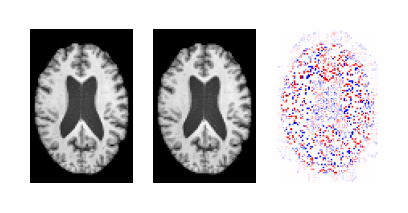

In [41]:
fig, ax = plt.subplots(1,3, figsize=(1.5,1.5))
obs_img = ndimage.rotate(obs['x'][1,0,:,:,37], 90)
ax[0].imshow(obs_img, 'gray')
ax[0].axis('off')

count_img = ndimage.rotate(count['x'][1,0,:,:,37], 90)
ax[1].imshow(count_img, 'gray')
ax[1].axis('off')

ax[2].imshow(obs_img - count_img, 'seismic')
ax[2].axis('off')

In [42]:
x = obs['x']
age = obs['age']
score = obs['score']
ventricle_volume = obs['ventricle_volume']
brain_volume = obs['brain_volume']
sex = obs['sex']
recon = loaded_model.reconstruct(x, age, score, sex, ventricle_volume, brain_volume, num_particles=6)

In [43]:
brain_volumes = 800. + 500 * torch.arange(3, dtype=torch.float)
brain_volume_range = torch.full((3,1), obs['brain_volume'][0].item())#brain_volumes.repeat(3).unsqueeze(1)

ventricle_volumes = 128.6820 - 62 * torch.arange(3, dtype=torch.float)
ventricle_volume_range = ventricle_volumes.repeat_interleave(1).unsqueeze(1)

z_range = z[0].repeat((3, 1))

cond_data = {'brain_volume': brain_volume_range, 'ventricle_volume': ventricle_volume_range, 'z': z_range}
samples, *_ = pyro.condition(loaded_model.sample, data=cond_data)(1)

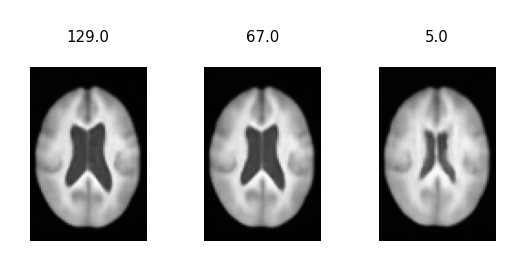

In [44]:
fig = plt.figure(figsize=(2, 2))
gs = fig.add_gridspec(1, 3, wspace=0.5, hspace=0.1)

for i in range(3):
    cond_sample = samples.data[i]
    
    ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
    ax.imshow(ndimage.rotate(cond_sample.squeeze()[:,:,37], 90), 'gray')
    ax.set(title=np.round(ventricle_volume_range[i].item(),0))
    
    ax.axis('off')



fig.tight_layout()

(-0.5, 63.5, 95.5, -0.5)

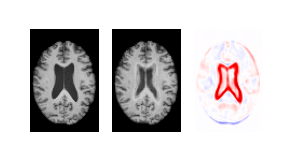

In [45]:
x = ndimage.rotate(obs['x'][0,0,:,:,37], 90)
x_129 = ndimage.rotate(recon[0,0,:,:,37], 90)
x_74 = ndimage.rotate(samples.data[1,0,:,:,37], 90)
x_19 = ndimage.rotate(samples.data[2,0,:,:,37], 90)


fig, axs = plt.subplots(1,3,figsize=(1,1))
axs[0].imshow(x, 'gray', vmin=0, vmax=255)
axs[0].axis('off')
axs[1].imshow(np.clip(x+(x_19-x_129), 0, 200), 'gray', vmin=0, vmax=250)
axs[1].axis('off')
axs[2].imshow(x_19-x_129, 'seismic', vmin=-200,vmax=200)
axs[2].axis('off')


In [101]:
diff = ((x_19-x_74)**3)/10000
df = pd.DataFrame()
i = 0
for x in np.arange(0,64,1):
    for y in np.arange(0,96,1):
        for z in np.arange(0,64,1):
            pixel = diff[0,x,y,z].item()
            if np.abs(pixel) > 20:
                df.loc[i, 'x'] = x
                df.loc[i, 'y'] = y
                df.loc[i, 'z'] = z             
                df.loc[i, 'intensity'] = pixel
            i += 1

In [93]:
def plot_3D_diff(diff):
    df = pd.DataFrame()
    i = 0
    for x in np.arange(0,64,1):
        for y in np.arange(0,96,1):
            for z in np.arange(0,64,1):
                pixel = diff[0,x,y,z].item()
                if np.abs(pixel) > 20:
                    df.loc[i, 'x'] = x
                    df.loc[i, 'y'] = y
                    df.loc[i, 'z'] = z             
                    df.loc[i, 'intensity'] = pixel
                i += 1
                
    fig = px.scatter_3d(df, x='x', y='y', z='z',
                        color='intensity', range_color=(-140,140),
                color_continuous_scale='RdBu',)
    fig.update_traces(marker=dict(size=8,opacity=0.05, line=dict(
                    width=0
                )),
                    selector=dict(mode='markers'))
    fig.update_layout(
        # scene = dict(
        #     xaxis = dict(visible=False),
        #     yaxis = dict(visible=False),
        #     zaxis =dict(visible=False)
        #     )
        )
    #fig.show()

In [66]:
x_74 = samples.data[1,:,:,:,:]
x_19 = samples.data[2,:,:,:,:]

plot_3D_diff(((x_19-x_74)**3)/10000)

In [81]:
test = obs['x'][0,0,:,:,:].numpy()

In [113]:
from skimage import measure
import plotly.graph_objects as go

# Assuming voxel_data is your 3D numpy array with brain scan values
voxel_data = test  # Replace with your actual data

# Apply Marching Cubes algorithm to get vertices and faces of the surface
verts, faces, _, _ = measure.marching_cubes(voxel_data, level=20)

# Vertices are the (x, y, z) coordinates of the mesh
x, y, z = verts.T  # Transpose to get x, y, z arrays

# Faces are the indices of the vertices that form triangles
i, j, k = faces.T

In [116]:
# Create the 3D surface plot using Plotly
fig = go.Figure(data=[
    go.Mesh3d(
        x=x, y=y, z=z, 
        i=i, j=j, k=k, 
        opacity=0.5,  # Set the opacity
        color='lightblue'  # Set a color for the surface
    )
])

fig.add_trace(
    go.Scatter3d(
        x=df.x, y=df.y, z=df.z,
        mode='markers',
        marker=dict(
            size=10,
            color=df.intensity,  # Color of the scatter points
            opacity=0.05,
            colorscale='RdBu',
            cmin=-140,
            cmax=140
        ),
        name='Points of Interest'  # Legend name
    )
)

# Set plot layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis=dict(showticklabels=False, showgrid=True),  # Hide tick labels, keep grid
        yaxis=dict(showticklabels=False, showgrid=True),  # Hide tick labels, keep grid
        zaxis=dict(showticklabels=False, showgrid=True),  
    ),
    title='3D Brain Surface'
)

# Show the plot
fig.show()


torch.Size([4, 1, 64, 96, 64])